In [1]:
from prophet import Prophet
import os
import pandas as pd

Importing plotly failed. Interactive plots will not work.


In [2]:
def load_data(platform, ticker, start_time, end_time, interval):
    """
    load data from ressources

    Args:
        - platform
        - ticker
        - start_time
        - end_time
        - interval
    Returns:
        - pd.Dataframe object with datetime as index
    """
    # set up file path
    filedir = os.path.join('/home/siegstedt/projects/trading',platform, 'data')
    filename = ticker + '_' + start_time + '_' + end_time + '_' + interval + '.csv'
    filepath = os.path.join(filedir, filename)
    # read in the data
    data = pd.read_csv(filepath, index_col=0, header=0).reset_index()
    #data = data.drop(columns=["datetime"])
    data.columns = ['ds','open','high','low','close','adj_close','volume']
    # reorder columns for having closed price accessible at the end of the data frame
    #data = data[['close','open','high','low','volume']]

    return data

In [3]:
def ask_prophet(data_in, col_in, n_periods=1):
    """
    Args:
        - data_in: input dataframe
        - col_in: list of cols to make prediction of
        - n_periods: number of predicted periods
    Returns:
        - pd.DataFrame object
    """
    data = data_in.copy()
    predictions = pd.DataFrame()
    
    for col in col_in:
        # select data
        df = data[['ds', col]]
        df.columns = ['ds','y']
        
        # fit model
        m = Prophet()
        m.fit(df)
        future = m.make_future_dataframe(periods=n_periods)
        
        # predict
        forecast = m.predict(future)
        
        # store result in original dataframe
        col_names = [col+i for i in ['_pred','_lower','_upper']]
        predictions[col_names] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
        
    #data_out = pd.concat([data,predictions])
    data_out = data.join(predictions, how='outer')
    return data_out

In [4]:
# read data input
data_input = load_data('binance', 'ethusd', '2015-08', '2021-02', '1d')
# slice down to last three years
three_years = data_input.shape[0] - (3 * 365)
data_input = data_input.loc[three_years:,:].reset_index(drop=True)
# ask prophet
n_periods = 30
data_pred = ask_prophet(data_input, ['close','high','low','volume'], n_periods)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [5]:
col_sel = ['close','close_pred','high','high_upper','low','low_lower','volume','volume_pred']
data_pred[col_sel].tail(10)

,close,close_pred,high,high_upper,low,low_lower,volume,volume_pred
1115,NaN,1696.083914,NaN,1880.755288,NaN,1508.623481,NaN,3.566048e+10
1116,NaN,1696.577284,NaN,1878.556465,NaN,1507.451410,NaN,3.603194e+10
1117,NaN,1701.261259,NaN,1880.866845,NaN,1503.101775,NaN,3.580401e+10
1118,NaN,1706.241960,NaN,1891.165194,NaN,1510.183850,NaN,3.490587e+10
1119,NaN,1708.648466,NaN,1893.605630,NaN,1510.136203,NaN,3.518395e+10
1120,NaN,1712.231649,NaN,1891.806146,NaN,1516.691480,NaN,3.636226e+10
1121,NaN,1713.640355,NaN,1896.453127,NaN,1520.574407,NaN,3.624171e+10
1122,NaN,1716.653608,NaN,1896.304862,NaN,1516.301884,NaN,3.627703e+10
1123,NaN,1717.970263,NaN,1904.248435,NaN,1514.427528,NaN,3.666924e+10
1124,NaN,1723.831024,NaN,1909.415416,NaN,1519.072184,NaN,3.646906e+10


<AxesSubplot:>

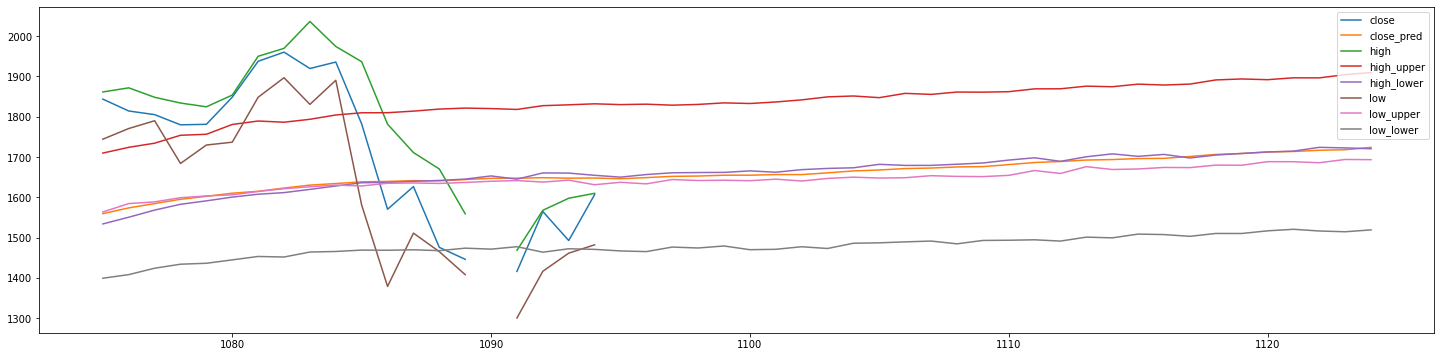

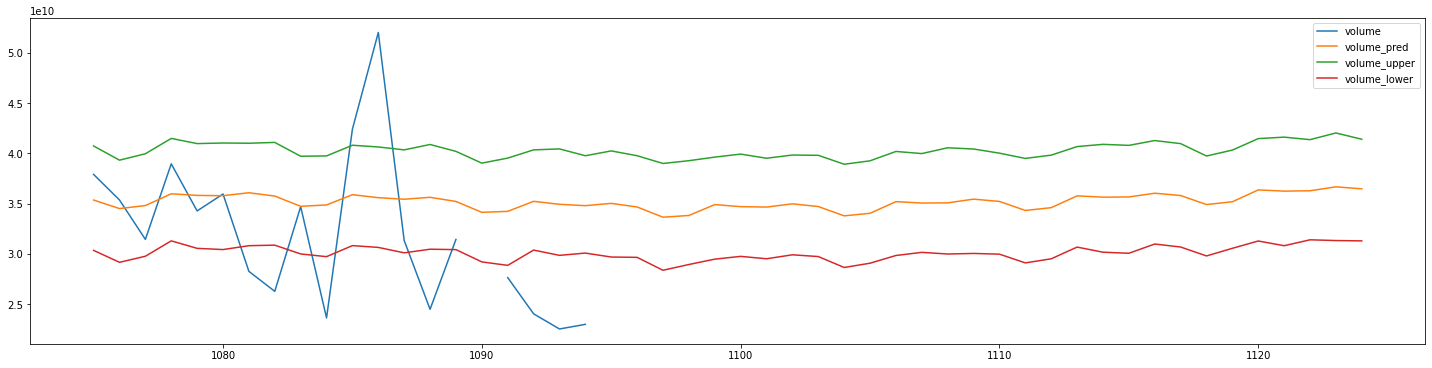

In [7]:
#col_sel = ['close','close_pred','high','high_pred','low','low_pred','volume','volume_pred']
col_sel = ['close','close_pred','high','high_upper','high_lower','low','low_upper','low_lower']
data_pred[col_sel].tail(50).plot(figsize=(25,6))
col_sel = ['volume','volume_pred','volume_upper','volume_lower']
data_pred[col_sel].tail(50).plot(figsize=(25,6))